In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        # activation
        self.data = data
        # gradient
        self.grad = 0.0

        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc
        self.label = label

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
                
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            # we do += to accumulate the gradient
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad

        out._backward = _backward
        return out


    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out
    

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/ (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        # topological sort, starting with vertices with edges going out
        topological_sorted_v = []
        visited = set()
        def build_topological_sort(v):
            if v not in visited:
                visited.add(v)
                # add all the node's children before adding itself
                for child in v._prev:
                    build_topological_sort(child)
                topological_sorted_v.append(v)

        build_topological_sort(self)
        self.grad = 1.0

        for v in reversed(topological_sorted_v):
            v._backward()

    
    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # self / other
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data})"
    

In [13]:
class Neuron:

    def __init__(self, num_weights):
        # Initialize weights as Value objects with random small values
        self.weights = [Value(random.uniform(-1, 1)) for _ in range(num_weights)]
        
        # Initialize bias as a Value object
        self.bias = Value(random.uniform(-1, 1))


    def forward(self, prev_activations):
        # Compute weighted sum
        weighted_sum = self.bias
        for prev_activation, weight in zip(prev_activations, self.weights):
            weighted_sum = weighted_sum.__add__(weight.__mul__(prev_activation))
            
        # Apply activation function (tanh)
        self.activation = weighted_sum.tanh()
        return self.activation

    def parameters(self):
        return self.weights + [self.bias]


        

class Layer:
    def __init__(self, num_prev_neurons, num_neurons):
        self.neurons = [Neuron(num_prev_neurons) for _ in range(num_neurons)]

    def forward(self, prev_activations):
        self.activations = [neuron.forward(prev_activations) for neuron in self.neurons]
        return self.activations

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]



class MLP:
    # inputs: number of inputs
    # layers: array of neuron counts: [2, 2, 1]
    def __init__(self, inputs, layers):
        self.layers = []
        total_layers = [inputs] + layers
        for i in range(len(layers)):
            self.layers.append(Layer(total_layers[i], total_layers[i+1]))
            
        # for layer by layer backprop, keep track of the last layer backproped
        self.next_layer_to_backward = len(self.layers)-1

    def forward(self, activations):
        # Pass activations through each layer
        for layer in self.layers:
            activations = layer.forward(activations)
        return activations

    # simulate "layer by layer" backpropagation
    # really, what's happening is the entire backprop is being recomputed and I'm zeroing out layer gradients
    def backward_one_layer(self, loss, layer_idx):
        if layer_idx > 0:
            self.next_layer_to_backward = layer_idx - 1
        else:
            self.next_layer_to_backward = len(self.layers) - 1
        
        # Compute fresh gradients
        loss.backward()
        
        # Zero out parameter gradients for layers before layer_idx
        all_prev_layers_params = set(p for layer in self.layers[:layer_idx] for p in layer.parameters())
        for p in self.parameters():
            if p in all_prev_layers_params:
                p.grad = 0.0

        # Zero out activation gradients for layers before layer_idx-1
        for layer in self.layers[:max(0, layer_idx - 1)]:
            for a in layer.activations:
                a.grad = 0.0

    def backward_button(self, target, inputs):
        # Reset all gradients (parameters and activations)
        for p in self.parameters():
            p.grad = 0.0
        for layer in self.layers:
            for a in layer.activations:
                a.grad = 0.0

        # Recompute forward pass and loss
        output = self.forward(inputs)
        loss = (output[0] - y[0])**2  # Assuming MSE loss
            
        # Compute gradients for the current layer
        self.backward_one_layer(loss, self.next_layer_to_backward)
        
        
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        
    

In [14]:
# Example usage
net = MLP(1, [2, 1])
x = [Value(0.5)]
y = [Value(0.75)]

output = net.forward(x)
print(f"Output: {output}")

# Assuming a simple loss like MSE
loss = (output[0] - y[0])**2
print(f"Loss: {loss.data}")

# Print gradients before any backprop
print("weight gradients before any backprop")
for i, layer in enumerate(net.layers):
    print(f"Layer {i} gradients:")
    for j, neuron in enumerate(layer.neurons):
        weight_grads = [w.grad for w in neuron.weights]  # Get all weight gradients
        print(f"  Neuron {j} weight gradients: {weight_grads}")


# Perform backward pass
print("weight gradients after backprop loss")
net.backward_button(y, x)
for i, layer in enumerate(net.layers):
    print(f"Layer {i} gradients:")
    for j, neuron in enumerate(layer.neurons):
        weight_grads = [w.grad for w in neuron.weights]  # Get all weight gradients
        print(f"  Neuron {j} weight gradients: {weight_grads}")


print("weight gradients after backprop third layer")
net.backward_button(y, x)
for i, layer in enumerate(net.layers):
    print(f"Layer {i} gradients:")
    for j, neuron in enumerate(layer.neurons):
        weight_grads = [w.grad for w in neuron.weights]  # Get all weight gradients
        print(f"  Neuron {j} weight gradients: {weight_grads}")


print("weight gradients after backprop second layer")
net.backward_button(y, x)
for i, layer in enumerate(net.layers):
    print(f"Layer {i} gradients:")
    for j, neuron in enumerate(layer.neurons):
        weight_grads = [w.grad for w in neuron.weights]  # Get all weight gradients
        print(f"  Neuron {j} weight gradients: {weight_grads}")


print("weight gradients after backprop first layer")
net.backward_button(y, x)
for i, layer in enumerate(net.layers):
    print(f"Layer {i} gradients:")
    for j, neuron in enumerate(layer.neurons):
        weight_grads = [w.grad for w in neuron.weights]  # Get all weight gradients
        print(f"  Neuron {j} weight gradients: {weight_grads}")

print("weight gradients after forward pass (should be the same as weight gradients before any backprop)")
for i, layer in enumerate(net.layers):
    print(f"Layer {i} gradients:")
    for j, neuron in enumerate(layer.neurons):
        weight_grads = [w.grad for w in neuron.weights]  # Get all weight gradients
        print(f"  Neuron {j} weight gradients: {weight_grads}")


print("weight gradients after backprop loss")
net.backward_button(y, x)
for i, layer in enumerate(net.layers):
    print(f"Layer {i} gradients:")
    for j, neuron in enumerate(layer.neurons):
        weight_grads = [w.grad for w in neuron.weights]  # Get all weight gradients
        print(f"  Neuron {j} weight gradients: {weight_grads}")


Output: [Value(data=0.001509433488656654)]
Loss: 0.5602381281564718
weight gradients before any backprop
Layer 0 gradients:
  Neuron 0 weight gradients: [0.0]
  Neuron 1 weight gradients: [0.0]
Layer 1 gradients:
  Neuron 0 weight gradients: [0.0, 0.0]
weight gradients after backprop loss
Layer 0 gradients:
  Neuron 0 weight gradients: [0.0]
  Neuron 1 weight gradients: [0.0]
Layer 1 gradients:
  Neuron 0 weight gradients: [0.42143190794759455, -0.20057145696548404]
weight gradients after backprop third layer
Layer 0 gradients:
  Neuron 0 weight gradients: [0.5991214335432982]
  Neuron 1 weight gradients: [-0.3989042065796925]
Layer 1 gradients:
  Neuron 0 weight gradients: [0.42143190794759455, -0.20057145696548404]
weight gradients after backprop second layer
Layer 0 gradients:
  Neuron 0 weight gradients: [0.0]
  Neuron 1 weight gradients: [0.0]
Layer 1 gradients:
  Neuron 0 weight gradients: [0.42143190794759455, -0.20057145696548404]
weight gradients after backprop first layer
Lay

In [15]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # LR = left to right || TB = top to bottom || BT = bottom to top

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            # If this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

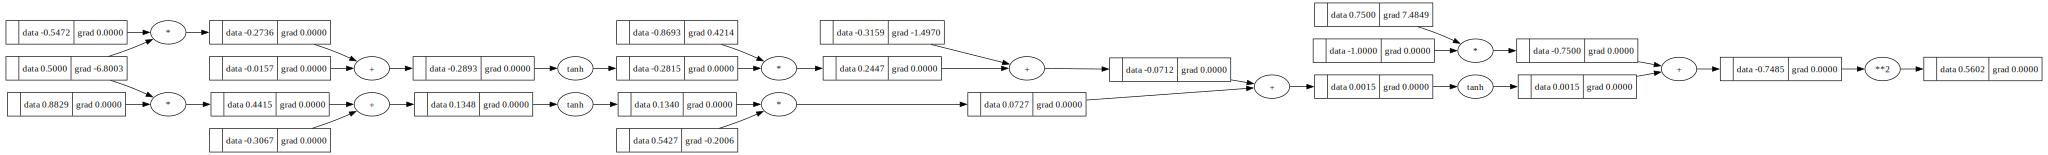

In [16]:
draw_dot(loss)

In [159]:
x = [2.0, 3.0, -1.0]
mlp = MLP(3, [4, 4, 1])
mlp.forward(x) 
print(len(mlp.parameters()))
print('---')
    
# Create the training set: inputs: xs[i], outputs: ys[i]
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

# Assuming mlp.forward(x) returns a list or array with a single element
for k in range(100):
    # Forward pass
    ypred = [mlp.forward(sample) for sample in xs]

    # For next token prediction, use cross entropy loss instead of the mean squared error loss as used here
    loss = 1 / len(ys) * sum((yout[0] - ygt)**2 for ygt, yout in zip(ys, ypred))

    # Initialize all the parameters's gradients to zero so they don't accumulate over each run of gradient descent
    for p in mlp.parameters():
        p.grad = 0.0

    # Backward pass
    loss.backward()

    # Stochastic gradient descent update
    for p in mlp.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)

print(loss)
print(ypred)


41
---
0 1.2153578629155062
1 0.9844567825838071
2 0.869205213288464
3 0.808764028595076
4 0.7617993517386195
5 0.7181257219171191
6 0.6725268217019904
7 0.6202090997470132
8 0.5560585246431388
9 0.47709749813546903
10 0.38896137647823226
11 0.3056318676078152
12 0.23744367821097537
13 0.18604389326728932
14 0.14837504404212584
15 0.12074102448842305
16 0.10019388256743444
17 0.084636927351904
18 0.07262979199830225
19 0.06318805629909671
20 0.05563359495838839
21 0.04949275715421798
22 0.044429255583948946
23 0.040200227489108585
24 0.03662731549240276
25 0.033577420437255874
26 0.030949711192436155
27 0.02866672387234808
28 0.026668168901669627
29 0.024906556882228613
30 0.023344064105464378
31 0.02195025528683373
32 0.0207004074527272
33 0.019574261113755334
34 0.018555079057030254
35 0.01762892930642846
36 0.016784133320464856
37 0.016010837312479976
38 0.015300676251200185
39 0.014646508299368432
40 0.014042203272673838
41 0.013482472882984636
42 0.012962733562846033
43 0.01247899